# Group 33 Project Proposal

Date: March 6th, 2021

Group Members: Kyra Priestman, Vita Chan, Alex Piarkouski, Shinichi Ishikawa

### Title

### Introduction

### Preliminary Exploratory Data Analysis

In [11]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#loading the necessary libraries
#functions needed to work with images
#code below sourced from: https://gist.github.com/daviddalpiaz/ae62ae5ccd0bada4b9acd6dbc9008706
#helper function for visualization
#show_digit = function(arr784, col = gray(12:1 / 12), ...) {
#image(matrix(as.matrix(arr784[-785]), nrow = 28)[, 28:1], col = col, ...)

In [26]:
#reading the data into R
#cleaning and wrangling the data 
#fire_data <- read_csv("Algerian_forest_fires_dataset_UPDATE.csv", skip=1, col_names = TRUE) %>%
#mutate(Classes = as_factor(Classes), 
#      FWI = as.numeric(FWI))
#renaming Classes to more descriptive title of "fire_occurence"
fire_data_1 <- (read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                       skip = 1, skip_empty_rows = TRUE, col_names = TRUE)[-c(123, 124, 168),]) %>%

mutate(Classes = as_factor(Classes), 
      Temperature = as.numeric(Temperature), 
      RH = as.numeric(RH),
      Ws = as.numeric(Ws),
      Rain = as.numeric(Rain),
      FWI = as.numeric(FWI),
      ) 

names(fire_data_1)[names(fire_data_1) == 'Classes'] <- 'fire_occurence'

fire_data_1

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,fire_occurence
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire


In [3]:
#Columns 1, 123, 124 are metadata, and are skipped, data for two regions is joined,
#Column names remain constant. Empty rows are skipped. Row 168 is formatted improperly
#- a delimiter is missing, the row is skipped 

In [27]:
fire_data_scaled <- fire_data_1 %>% 
 mutate(scaled_Temperature = scale(Temperature, center = TRUE), 
        scaled_RH = scale(RH, center = TRUE),
        scaled_Ws = scale(Ws, center = TRUE),
        scaled_Rain = scale(Rain, center = TRUE), 
        scaled_FWI = scale(FWI, center = TRUE))

fire_data_refined <- fire_data_scaled %>%
select(scaled_Temperature, scaled_RH, scaled_Ws, scaled_Rain, scaled_FWI, fire_occurence)
fire_data_refined

#*Say why we chose these for our predictors*

scaled_Temperature,scaled_RH,scaled_Ws,scaled_Rain,scaled_FWI,fire_occurence
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-0.8688614,-0.33997153,0.8914370,-0.3808708,-0.8783457,not fire
-0.8688614,-0.07021453,-0.8870457,0.2680887,-0.8917856,not fire
-1.6957543,1.34600973,2.3142231,6.1586438,-0.9321051,not fire
⋮,⋮,⋮,⋮,⋮,⋮
-1.420123,1.6832060,4.8040988,-0.1312710,-0.9186652,not fire
-2.247016,-0.5422893,0.8914370,-0.3309508,-0.8514661,not fire
-2.247016,0.1321032,-0.1756526,-0.2810309,-0.8783457,not fire


In [29]:
#Splitting the data into training and test sets (only the training set will be used for creating the below tables and visualizations)

#Filtering first for our desired predictors and Class variable
filtered_fire <- fire_data_refined %>%
select(scaled_Temperature, scaled_RH, scaled_Ws, scaled_Rain, scaled_FWI, fire_occurence)

#Splitting into training and test sets
fire_split <- initial_split(filtered_fire, prop = 0.75, strata = fire_occurence)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)
fire_train
fire_test

scaled_Temperature,scaled_RH,scaled_Ws,scaled_Rain,scaled_FWI,fire_occurence
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-0.8688614,-0.33997153,0.8914370,-0.3808708,-0.8783457,not fire
-0.8688614,-0.07021453,-0.8870457,0.2680887,-0.8917856,not fire
-1.9713852,1.81808448,-0.8870457,0.8671282,-0.9455449,not fire
⋮,⋮,⋮,⋮,⋮,⋮
-1.144492,1.6832060,-0.1756526,1.8156074,-0.9455449,not fire
-1.420123,1.6832060,4.8040988,-0.1312710,-0.9186652,not fire
-2.247016,-0.5422893,0.8914370,-0.3309508,-0.8514661,not fire


scaled_Temperature,scaled_RH,scaled_Ws,scaled_Rain,scaled_FWI,fire_occurence
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-1.6957543,1.3460097,2.3142231,6.1586438,-0.93210508,not fire
-0.3175995,0.3344210,-0.5313491,-0.3808708,-0.60954904,fire
0.2336625,-0.5422893,-0.8870457,-0.3808708,0.02212318,fire
⋮,⋮,⋮,⋮,⋮,⋮
-0.8688614,-1.4189995,-2.6655283,-0.3309508,-0.1929142,fire
0.5092934,-0.2725323,-0.8870457,-0.2810309,-0.4348312,not fire
-2.2470162,0.1321032,-0.1756526,-0.2810309,-0.8783457,not fire


In [39]:
#Summarizing the data in a table
#Checking to see if the number of observations for each whether a fire occured or not is similar, otherwise the model won't be properly trained

observations_classes <- fire_train %>%  
    select(fire_occurence) %>%  
    group_by(fire_occurence) %>%  
    summarize(n = n(),
            percentage = n() / nrow(fire_train) * 100)
observations_classes

`summarise()` ungrouping output (override with `.groups` argument)



fire_occurence,n,percentage
<fct>,<int>,<dbl>
not fire,80,43.71585
fire,103,56.28415


We can see that there were 23 more observations for the fire Class. Considering that we are trying to find out which attributes are most likely to results in a fire occuring, our results should not be skewed by this slight difference in number of observations. With more "fire" observations, we can even observe the common attributes within this Class, as they all resulted in a fire occuring (e.g. increased rain was common throughout most of the "fire" observations). 

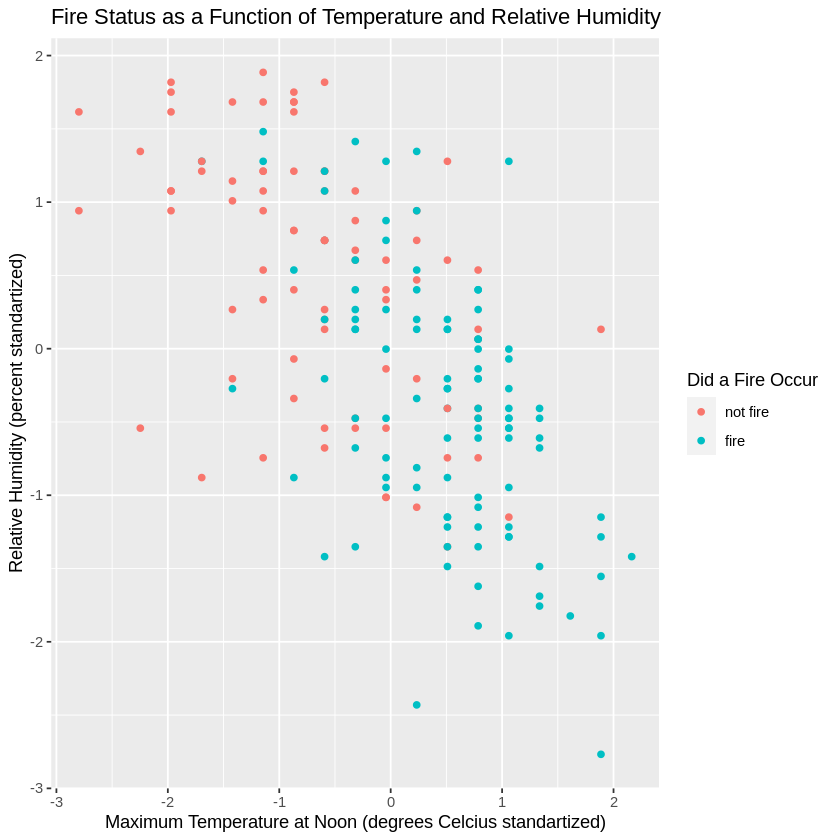

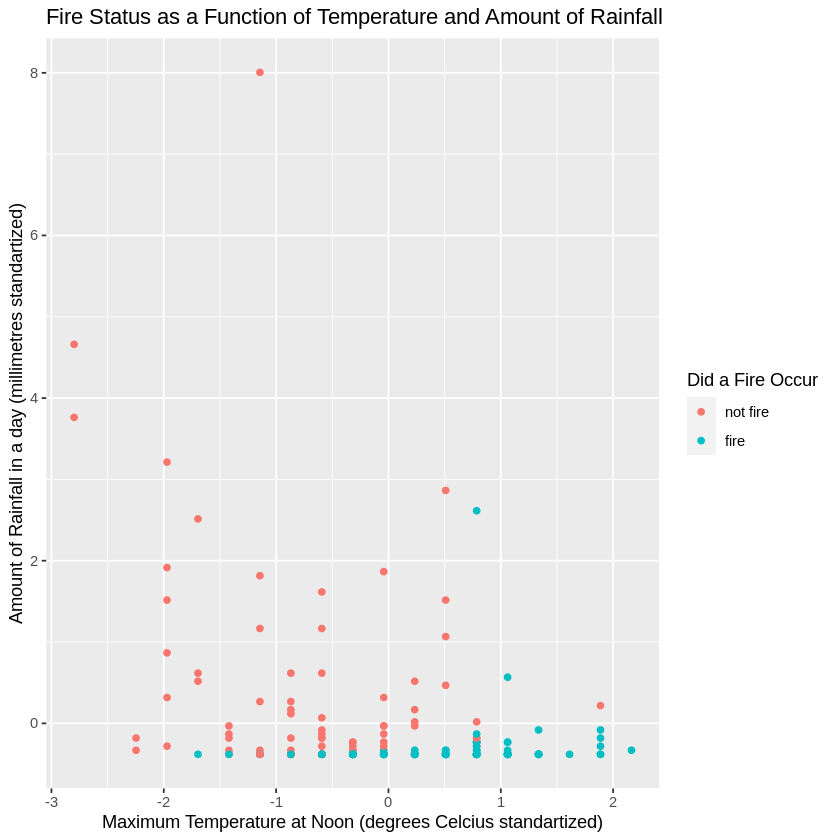

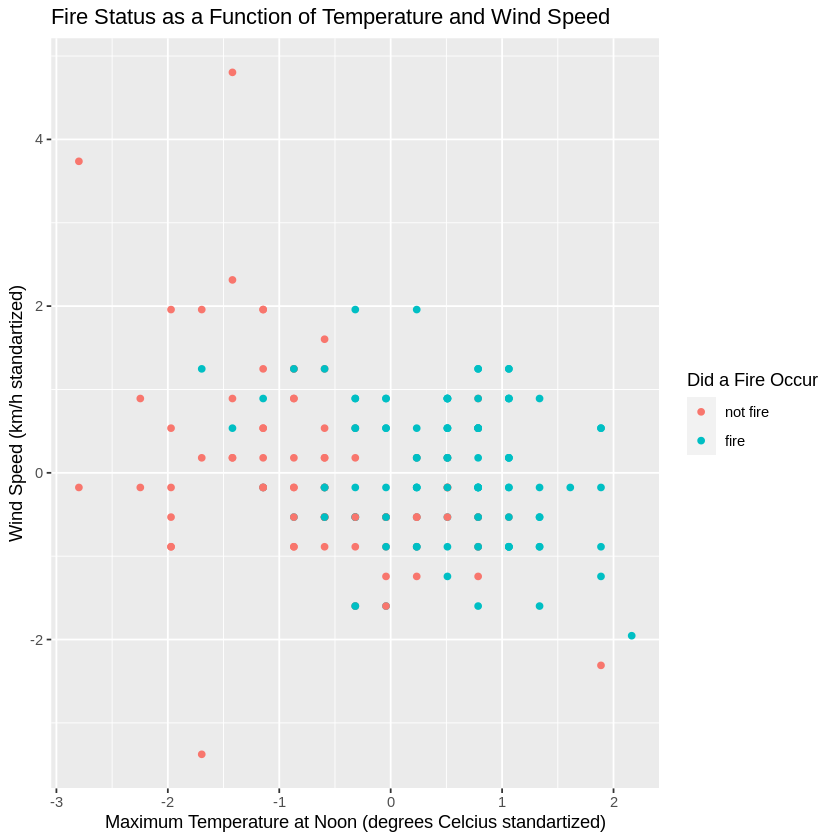

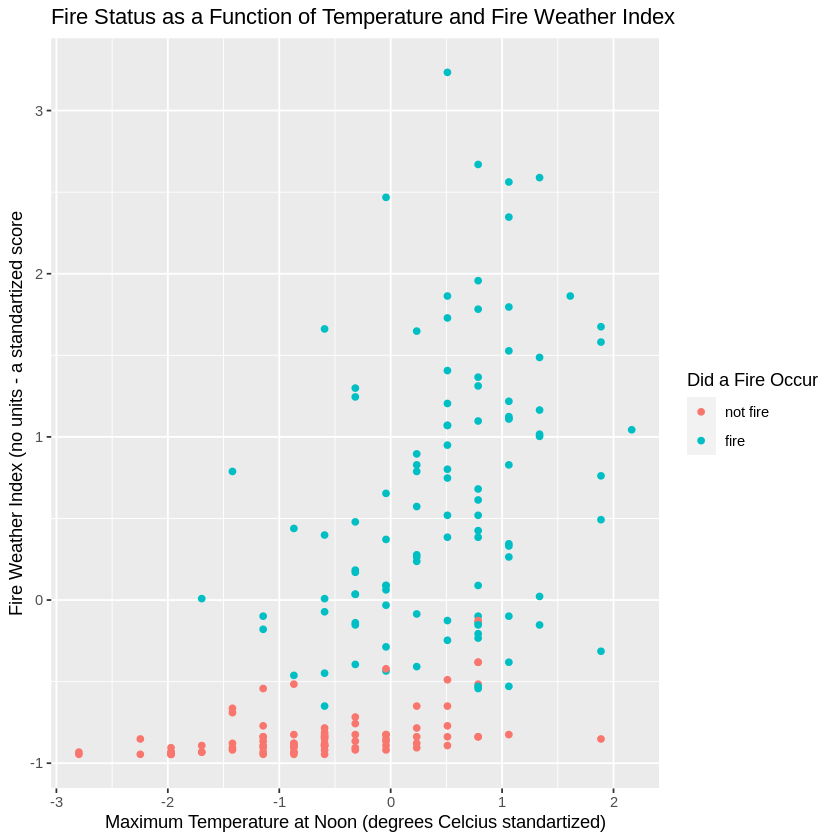

In [38]:
#Creating visualizations
temperature_humidity_plot <- fire_train %>%
    ggplot(aes(x = scaled_Temperature, y = scaled_RH, colour = fire_occurence)) +
geom_point() + 
labs(x = "Maximum Temperature at Noon (degrees Celcius standartized)",
     y = "Relative Humidity (percent standartized)",
    colour = "Did a Fire Occur") +
ggtitle("Fire Status as a Function of Temperature and Relative Humidity")
temperature_humidity_plot

temperature_rain_plot <- fire_train %>%
    ggplot(aes(x = scaled_Temperature, y = scaled_Rain, colour = fire_occurence))+
geom_point() +
labs(x = "Maximum Temperature at Noon (degrees Celcius standartized)",
     y = "Amount of Rainfall in a day (millimetres standartized)",
    colour = "Did a Fire Occur") +
ggtitle("Fire Status as a Function of Temperature and Amount of Rainfall")
temperature_rain_plot

temperature_wind_plot <- fire_train %>%
    ggplot(aes(x = scaled_Temperature, y = scaled_Ws, colour = fire_occurence))+
geom_point() +
labs(x = "Maximum Temperature at Noon (degrees Celcius standartized)",
     y = "Wind Speed (km/h standartized)",
    colour = "Did a Fire Occur") +
ggtitle("Fire Status as a Function of Temperature and Wind Speed")
temperature_wind_plot

temperature_FWI_plot <- fire_train %>%
    ggplot(aes(x = scaled_Temperature, y = scaled_FWI, colour = fire_occurence))+
geom_point() +
labs(x = "Maximum Temperature at Noon (degrees Celcius standartized)",
     y = "Fire Weather Index (no units - a standartized score",
    colour = "Did a Fire Occur") +
ggtitle("Fire Status as a Function of Temperature and Fire Weather Index")
temperature_FWI_plot

### Methods

### Expected outcomes and significance